In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [2]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')


In [3]:
class Model():
    def __init__(self, params=None):
        self.model = None
        if params is None:
            params={}
        else:
            self.params = params
    def fit(self,x_train,y_train,x_test,y_test):
        dm_train = xgb.DMatrix(x_train, label=y_train)
        dm_test = xgb.DMatrix(x_test,y_test)


        num_round = 5000
        evallist = [(dm_train, 'train'), (dm_test, 'eval')]

        evals_result = {}

        #パラメータ
        param = {'learning_rate':0.01,
                 'n_estimators':3460,
                 'max_depth':3,
                 'min_child_weight':0,
                 'gamma':0,
                 'subsample':0.7,
                 'colsample_bytree':0.7,
                 #objective:'reg:linear', 
                 'nthread':-1,
                 'scale_pos_weight':1,
                 'seed':27,
                 'reg_alpha':0.00006
                    }


        #学習の実行
        self.model = xgb.train(
                        param, dm_train,
                        num_round,)
        
        
        
    
    def pred(self,x):
        data = xgb.DMatrix(x)
        pred = self.model.predict(data)
        return pred

In [4]:
pd.set_option('display.max_rows',10)
#trainデータを価格とそれ以外で分割
train_x = train.drop('SalePrice',axis=1)
train_y = train['SalePrice']

all_data = pd.concat([train_x,test],axis=0,sort=True)
train_ID=train_x['Id']
test_ID=test['Id']

all_data.drop('Id',axis=1,inplace=True)
print('X:'+str(train_x.shape))
print('y:'+str(train_y.shape))
print('test:'+str(test.shape))
print('all_data:'+str(all_data.shape))


X:(1460, 80)
y:(1460,)
test:(1459, 80)
all_data:(2919, 79)


In [5]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['YearbltRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

# カテゴリ変数に変換する
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# 誤記データ変換
all_data=all_data.replace({'Exterior2nd':{'Brk Cmn':'BrkComm','Wd Shng':'Wd Sdng'}})

#ラベルエンコード
#label_col=['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC','BsmtExposure','BsmtFinType1','BsmtFinType2','KitchenAbvGr','FullBath','HalfBath','Fence','BedroomAbvGr']
#all_data[label_col]=all_data[label_col].astype(str)
#for c in label_col:
#    le = LabelEncoder()
#    le.fit(all_data[c])
#    all_data[c] = le.transform(all_data[c])

#one-hot

#target_col=['Street','Alley','CentralAir','YrSold']
#all_data = pd.get_dummies(all_data,columns=target_col)
all_data = pd.get_dummies(all_data).reset_index(drop=True)

In [6]:
train_x2=all_data.iloc[:train_x.shape[0],:].reset_index(drop=True)
test_x=all_data.iloc[train_x.shape[0]:,:].reset_index(drop=True)

print("train_x2: "+str(train_x2.shape))
print("test_x: "+str(test_x.shape))

train_x2: (1460, 319)
test_x: (1459, 319)


In [7]:
#x_train, x_test, y_train, y_test = train_test_split(train_x2, train_y, test_size=100, random_state=1)
scores = []
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x2):
    tr_x, va_x = train_x2.iloc[tr_idx], train_x2.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    
    model = Model()
    model.fit(tr_x, tr_y, va_x, va_y)
    va_pred = model.pred(va_x)
    score = np.sqrt(mean_squared_error(np.log(va_y), np.log(va_pred)))
    print(f'RMSE: {score:.4f}')
    scores.append(score)
    
print(np.mean(scores))


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 0.1287


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 0.1181


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 0.1346


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 0.1050
0.12162125960735656


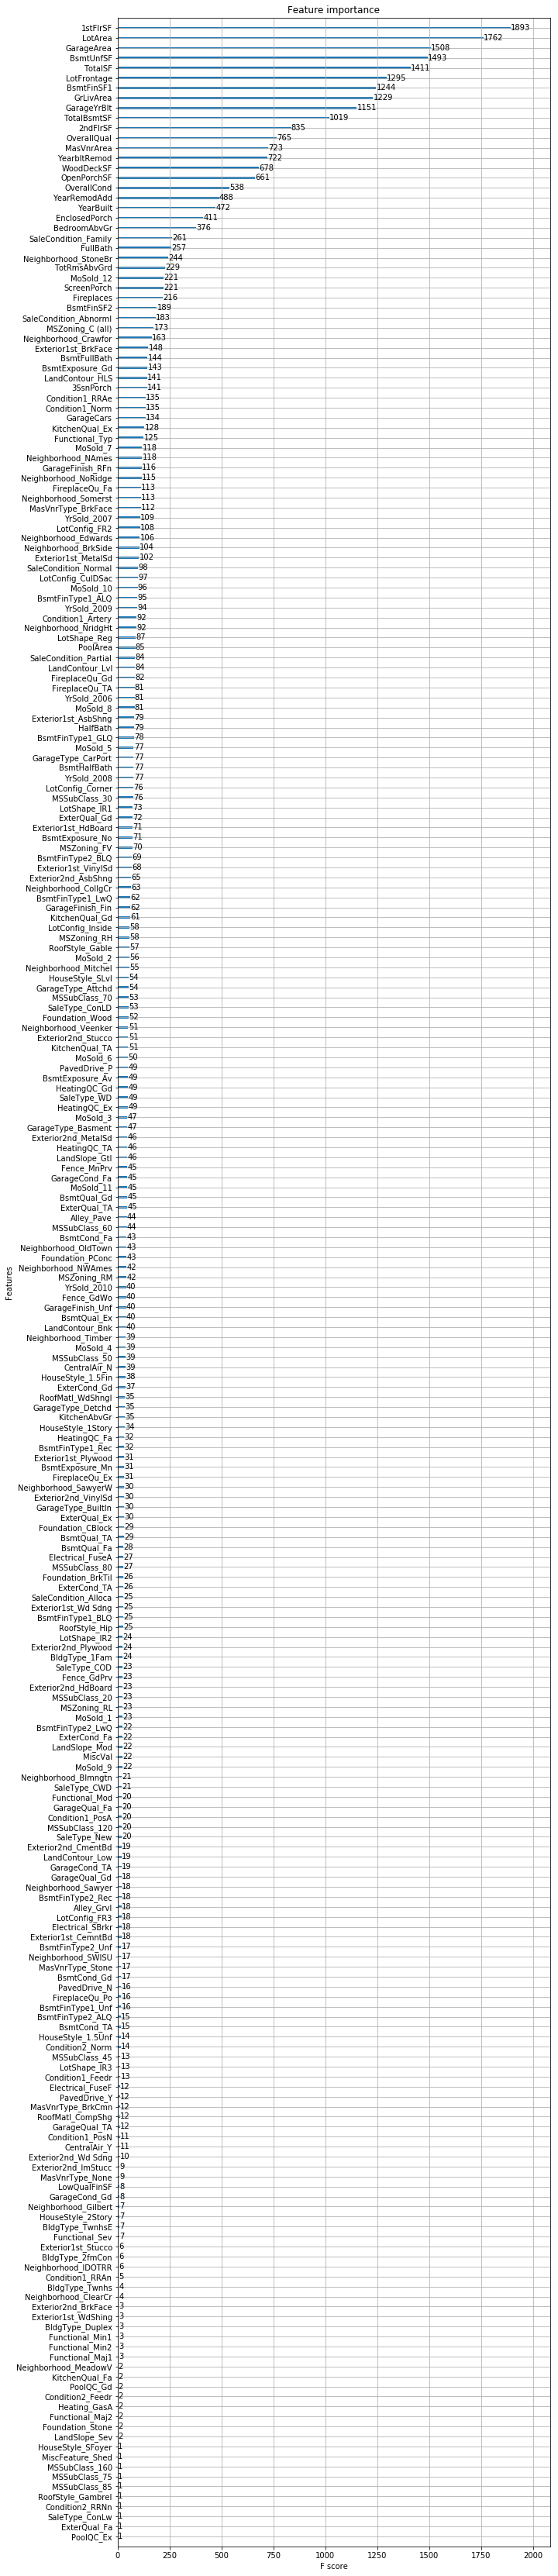

In [8]:
ax = xgb.plot_importance(model.model)
fig =ax.figure
fig.set_size_inches(10,60)

In [9]:

pred=model.pred(test_x)
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred})
submission['SalePrice']=submission['SalePrice']
submission.to_csv('submission.csv', index=False)

In [10]:
submission

,Id,SalePrice
0,1461,128681.132812
1,1462,164234.593750
2,1463,187253.140625
3,1464,192738.968750
4,1465,179864.828125
...,...,...
1454,2915,80478.687500
1455,2916,82266.875000
1456,2917,166783.718750
1457,2918,122513.101562
